In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

def first_binomial_call(S, K, T, r, u, d, N):
    dt = T/N
    p = (math.exp(r*dt)-d)/(u-d)
    C = {}
    for m in range(0, N+1):
            C[(N, m)] = max(0,S*(u**(m))*(d**(N-m))-K)
    for k in range(N-1, -1, -1):
        for m in range(0,k+1):
            C[(k, m)] = (math.exp(-r*dt))*(p*C[(k+1,m+1)]+(1-p)*C[(k+1,m)])
    return C

In [ ]:
import matplotlib.pyplot as plt
call = []
maxx=0
for N in range(1,1000,10):
  call_price = first_binomial_call(100, 100, 1, 0, 1.2, 0.8, N)
#   print(call_price)
  maxx=max(maxx,max(call_price.values()))  
  call.append(call_price)
print(maxx)
call = pd.DataFrame(call)
call.plot()

2.941811444713696e+80


In [1]:
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

def euro_vanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [2]:
euro_vanilla( 80, 100, 1, 0.02/252, .25,  'call')

2.266816097057781

In [3]:
# Fetching nifty_data
import pandas as pd

nifty_data = pd.read_csv("Option_data_NIFTY.csv")

nifty_data.head()


,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value,Time to Expiry
0,NIFTY,10/11/2017,12/28/2017,CE,10100,342.00,384.55,319.95,346.65,357.25,346.65,369,2891.94,96.77,270000,6000,10321.75,48
1,NIFTY,10/11/2017,12/28/2017,CE,10200,274.05,308.15,246.00,280.10,288.00,280.10,814,6395.29,168.19,463125,1200,10321.75,48
2,NIFTY,10/11/2017,12/28/2017,CE,10300,213.15,239.05,184.95,214.45,220.00,214.45,2489,19614.17,386.64,583650,7725,10321.75,48
3,NIFTY,10/11/2017,12/28/2017,CE,10400,156.10,177.75,133.40,153.65,161.45,153.65,2648,20963.42,309.02,436650,3675,10321.75,48
4,NIFTY,10/11/2017,12/28/2017,CE,10500,117.45,128.45,92.60,112.20,117.70,112.20,8500,67640.94,703.44,1862175,2625,10321.75,48


In [4]:
# Pick a Strike of your choice. Calculate required inputs for pricing the call and put option of that strike for all the dates
from statistics import stdev 
import numpy as np

Strike_Price = 10100
new_data = nifty_data[nifty_data['Strike Price'] == Strike_Price]
new_data['volatility'] = 0
vv=[0]
for i in range(1,len(new_data)):
#     a =  np.log((new_data.iloc[i, new_data.columns.get_loc('Settle Price')])/(new_data.iloc[i-1, new_data.columns.get_loc('Settle Price')]))
    a =  np.log(float(new_data['Settle Price'].iloc[[i]])/float(new_data['Settle Price'].iloc[[i]]))
    vv.append(a)
    new_data.iloc[i, new_data.columns.get_loc('volatility')]= stdev(vv)
new_data['Theoritical_Call'] = 0
new_data['Theoritical_Put'] = 0

new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data.index  = new_data['Date'] 

for i in range(len(new_data)):
  new_data['Theoritical_Call'][i] = euro_vanilla(S = new_data['Underlying Value'][i], K = new_data['Strike Price'][i], T = new_data['Time to Expiry'][i] , r = .04, sigma= new_data['volatility'][i] , option = 'call')
  new_data['Theoritical_Put'][i] = euro_vanilla(S = new_data['Underlying Value'][i], K = new_data['Strike Price'][i], T = new_data['Time to Expiry'][i] , r = .04, sigma= new_data['volatility'][i] , option = 'put')


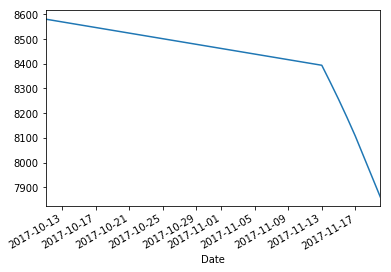

In [6]:
import matplotlib.pyplot as plt
new_data['Put_Call_Parity'] = new_data['Theoritical_Call'] - new_data['Theoritical_Put'] - new_data['Underlying Value'] + new_data['Strike Price']*np.exp(-0.02/252 * new_data['Time to Expiry'])
new_data['Put_Call_Parity'].plot()